In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split

In [ ]:
!unzip "/content/ktfeJAFFE.zip" -d "/content"

Archive:  /content/ktfeJAFFE.zip
   creating: /content/ktfeJAFFE/anger/
  inflating: /content/ktfeJAFFE/anger/KA.AN1.39.tiff  
  inflating: /content/ktfeJAFFE/anger/KA.AN2.40.tiff  
  inflating: /content/ktfeJAFFE/anger/KA.AN3.41.tiff  
  inflating: /content/ktfeJAFFE/anger/KL.AN1.167.tiff  
  inflating: /content/ktfeJAFFE/anger/KL.AN2.168.tiff  
  inflating: /content/ktfeJAFFE/anger/KL.AN3.169.tiff  
  inflating: /content/ktfeJAFFE/anger/KM.AN1.17.tiff  
  inflating: /content/ktfeJAFFE/anger/KM.AN2.18.tiff  
  inflating: /content/ktfeJAFFE/anger/KM.AN3.19.tiff  
  inflating: /content/ktfeJAFFE/anger/KR.AN1.83.tiff  
  inflating: /content/ktfeJAFFE/anger/KR.AN2.84.tiff  
  inflating: /content/ktfeJAFFE/anger/KR.AN3.85.tiff  
  inflating: /content/ktfeJAFFE/anger/MK.AN1.125.tiff  
  inflating: /content/ktfeJAFFE/anger/MK.AN2.126.tiff  
  inflating: /content/ktfeJAFFE/anger/MK.AN3.127.tiff  
  inflating: /content/ktfeJAFFE/anger/NA.AN1.211.tiff  
  inflating: /content/ktfeJAFFE/anger/NA.

In [ ]:
# Dataset path
data_dir = "/content/ktfeJAFFE"

In [ ]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
# Load full dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Split dataset into train and validation sets
train_size = int(0.8 * len(full_dataset))  # 80% for training
val_size = len(full_dataset) - train_size  # 20% for validation
train_set, val_set = random_split(full_dataset, [train_size, val_size])

# Data loaders
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

# Print class labels and names
class_names = full_dataset.classes
class_to_idx = full_dataset.class_to_idx
print("Class Labels and Corresponding Class Names:")
for label, name in class_to_idx.items():
    print(f"Label {name}: {label}")

# Verify dataset sizes
print(f"Total images: {len(full_dataset)}, Train: {len(train_set)}, Validation: {len(val_set)}")

Class Labels and Corresponding Class Names:
Label 0: anger
Label 1: disgust
Label 2: fear
Label 3: happy
Label 4: neutral
Label 5: sad
Label 6: surprise
Total images: 4450, Train: 3560, Validation: 890


In [ ]:
# Load pre-trained VGG16 model
model = models.vgg16(pretrained=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Modify classifier for our dataset
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, len(full_dataset.classes))
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [ ]:
# Early Stopping
from torch.optim import lr_scheduler

# Early stopping utility
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0  # Reset counter
        else:
            self.counter += 1  # Increase counter if no improvement
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered! 🚀")


early_stopping = EarlyStopping(patience=5, verbose=True)  # Stop if val loss doesn't improve in 5 epochs


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10, patience=5, save_path="best_model.pth"):
    train_loss_history, val_acc_history, train_acc_history = [], [], []
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    best_val_acc = 0.0  # Track the best validation accuracy

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0

        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")

        for batch_idx, (images, labels) in progress_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            # Update progress bar with loss and train accuracy
            progress_bar.set_postfix(loss=running_loss / (batch_idx + 1), train_acc=correct_train / total_train)

        train_loss_history.append(running_loss / len(train_loader))
        train_acc = correct_train / total_train
        train_acc_history.append(train_acc)

        # Validation phase
        model.eval()
        correct_val, total_val, val_loss = 0, 0, 0.0

        with torch.no_grad():
            val_progress_bar = tqdm(enumerate(val_loader), total=len(val_loader), desc="Validating")

            for batch_idx, (images, labels) in val_progress_bar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

                # Update validation progress bar
                val_progress_bar.set_postfix(val_acc=correct_val / total_val)

        val_loss /= len(val_loader)
        val_acc = correct_val / total_val
        val_acc_history.append(val_acc)

        print(f"Epoch {epoch+1}: Train Loss={running_loss / len(train_loader):.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

        # Save model if validation accuracy improves
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)
            print(f"Best model saved at epoch {epoch+1} with Val Acc={best_val_acc:.4f}")

        # Step the scheduler
        scheduler.step(val_loss)

        # Check early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

    return train_loss_history, train_acc_history, val_acc_history

In [ ]:
train_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=5, save_path="best_model.pth")


Validating: 100%|██████████| 28/28 [00:05<00:00,  4.95it/s, val_acc=0.89]


Epoch 1: Train Loss=0.0131, Train Acc=0.9961, Val Loss=0.5973, Val Acc=0.8899
Best model saved at epoch 1 with Val Acc=0.8899


Validating: 100%|██████████| 28/28 [00:05<00:00,  4.84it/s, val_acc=0.876]


Epoch 2: Train Loss=0.0132, Train Acc=0.9949, Val Loss=0.5911, Val Acc=0.8764


Validating: 100%|██████████| 28/28 [00:05<00:00,  4.81it/s, val_acc=0.867]


Epoch 3: Train Loss=0.0606, Train Acc=0.9789, Val Loss=0.5695, Val Acc=0.8674


Validating: 100%|██████████| 28/28 [00:05<00:00,  4.73it/s, val_acc=0.821]


Epoch 4: Train Loss=0.0498, Train Acc=0.9885, Val Loss=0.7247, Val Acc=0.8213


Validating: 100%|██████████| 28/28 [00:05<00:00,  4.70it/s, val_acc=0.869]


Epoch 5: Train Loss=0.0686, Train Acc=0.9753, Val Loss=0.5263, Val Acc=0.8685


Validating: 100%|██████████| 28/28 [00:05<00:00,  4.76it/s, val_acc=0.864]


Epoch 6: Train Loss=0.0373, Train Acc=0.9882, Val Loss=0.6056, Val Acc=0.8640


Validating: 100%|██████████| 28/28 [00:06<00:00,  4.63it/s, val_acc=0.897]


Epoch 7: Train Loss=0.0423, Train Acc=0.9860, Val Loss=0.5110, Val Acc=0.8966
Best model saved at epoch 7 with Val Acc=0.8966


Validating: 100%|██████████| 28/28 [00:05<00:00,  4.74it/s, val_acc=0.899]


Epoch 8: Train Loss=0.0197, Train Acc=0.9955, Val Loss=0.4348, Val Acc=0.8989
Best model saved at epoch 8 with Val Acc=0.8989


Validating: 100%|██████████| 28/28 [00:05<00:00,  4.75it/s, val_acc=0.889]


Epoch 9: Train Loss=0.0434, Train Acc=0.9882, Val Loss=0.5289, Val Acc=0.8888


Validating: 100%|██████████| 28/28 [00:06<00:00,  4.63it/s, val_acc=0.865]


Epoch 10: Train Loss=0.0508, Train Acc=0.9843, Val Loss=0.6138, Val Acc=0.8652


Validating: 100%|██████████| 28/28 [00:05<00:00,  4.72it/s, val_acc=0.874]


Epoch 11: Train Loss=0.0663, Train Acc=0.9795, Val Loss=0.5658, Val Acc=0.8742


Validating: 100%|██████████| 28/28 [00:06<00:00,  4.60it/s, val_acc=0.888]


Epoch 12: Train Loss=0.0389, Train Acc=0.9874, Val Loss=0.5719, Val Acc=0.8876


Validating: 100%|██████████| 28/28 [00:05<00:00,  4.67it/s, val_acc=0.882]

Epoch 13: Train Loss=0.0189, Train Acc=0.9955, Val Loss=0.5181, Val Acc=0.8820
Early stopping triggered! 🚀
Early stopping triggered.


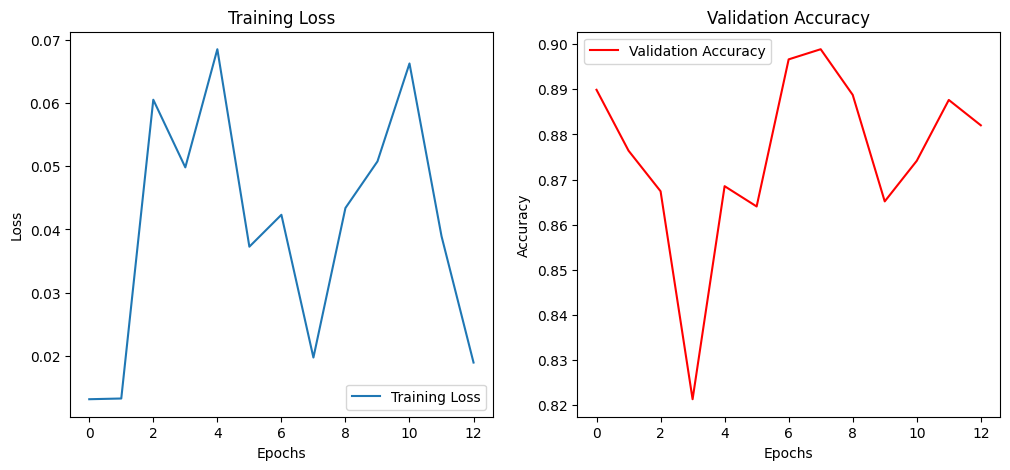

In [ ]:
# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_acc, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.show()

In [ ]:
# Prediction function to visualize results
def plot_predictions(model, test_loader, class_names, num_images=8):
    model.eval()
    images_shown, fig = 0, plt.figure(figsize=(12, 8))

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(images.shape[0]):
                if images_shown == num_images:
                    plt.show()
                    return

                ax = fig.add_subplot(2, num_images//2, images_shown + 1, xticks=[], yticks=[])
                img = images[i].cpu().numpy().transpose((1, 2, 0))
                img = np.clip(img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)  # Denormalize
                ax.imshow(img)
                ax.set_title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}", color=("green" if labels[i] == preds[i] else "red"))
                images_shown += 1
    plt.show()

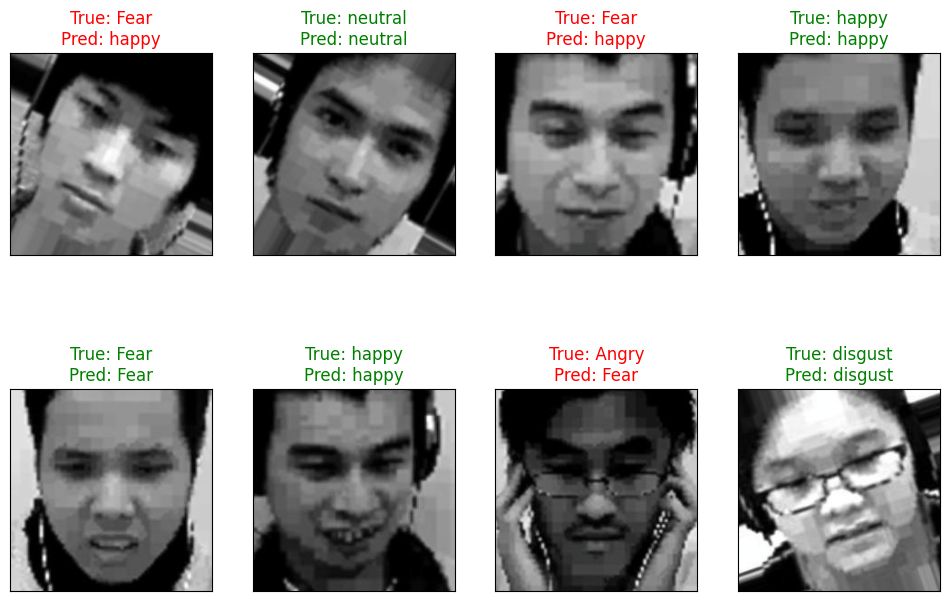

In [ ]:
plot_predictions(model, val_loader, class_names, num_images=8)

In [ ]:
import torch
import numpy as np
from collections import defaultdict

# Function to compute class-wise accuracy
def compute_classwise_accuracy(model, dataloader, device, class_names):
    model.eval()  # Set model to evaluation mode
    correct_preds = defaultdict(int)  # Correct predictions per class
    total_preds = defaultdict(int)  # Total instances per class

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)  # Forward pass
            _, preds = torch.max(outputs, 1)  # Get predicted class

            # Count correct and total predictions per class
            for label, pred in zip(labels.cpu().numpy(), preds.cpu().numpy()):
                total_preds[label] += 1
                if label == pred:
                    correct_preds[label] += 1

    # Print accuracy per class
    print("\nClass-wise Accuracy:")
    for class_idx, class_name in enumerate(class_names):
        accuracy = 100 * correct_preds[class_idx] / max(1, total_preds[class_idx])  # Avoid division by zero
        print(f"{class_name}: {accuracy:.2f}%")

# Example usage
# Define class names for CK+ dataset (Modify based on your dataset)
class_names = ["Angry", "disgust","Fear", "happy", "neutral","Sad", "Surprise"]

# Assuming you have a test dataloader named `test_loader`
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
compute_classwise_accuracy(model, val_loader, device, class_names)



Class-wise Accuracy:
Angry: 77.78%
disgust: 96.30%
Fear: 66.36%
happy: 95.24%
neutral: 84.82%
Sad: 93.33%
Surprise: 86.89%


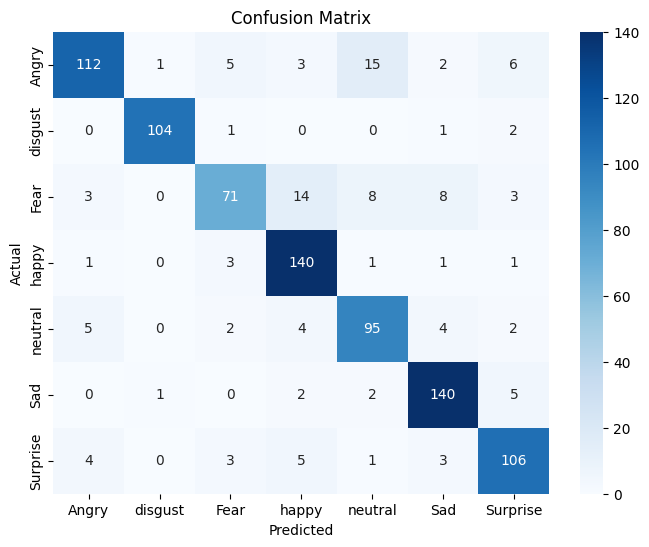

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, dataloader, class_names, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# Run this
plot_confusion_matrix(model, val_loader, class_names = ["Angry", "disgust","Fear", "happy", "neutral","Sad", "Surprise"], device=device)
